In [1]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from os import listdir
from sklearn.model_selection import train_test_split

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, Conv1D, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
mfcc_files = ['../data/mfcc/' + f for f in listdir('../data/mfcc/') if 'mfcc.pkl' in f]
target_files = ['../data/target/' + f for f in listdir('../data/target/') if 'target.pkl' in f]

mfcc_files.sort()
target_files.sort()

In [4]:
def reload(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [5]:
mfcc_reloaded = [reload(f) for f in mfcc_files]
target_reloaded = [reload(f) for f in target_files]

In [6]:
mfcc_files

['../data/mfcc/en_12130n_20mfcc.pkl',
 '../data/mfcc/es_11763n_20mfcc.pkl',
 '../data/mfcc/fr_10894n_20mfcc.pkl',
 '../data/mfcc/ru_11848n_20mfcc.pkl',
 '../data/mfcc/zh_11067n_20mfcc.pkl']

In [7]:
target_files

['../data/target/en_12130n_target.pkl',
 '../data/target/es_11763n_target.pkl',
 '../data/target/fr_10894n_target.pkl',
 '../data/target/ru_11848n_target.pkl',
 '../data/target/zh_11067n_target.pkl']

In [8]:
X = np.concatenate(mfcc_reloaded)

In [9]:
y = np.concatenate(target_reloaded)

In [10]:
# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

In [11]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y)

In [38]:
model = Sequential()
model.add(BatchNormalization())
model.add(Conv2D(filters = 10, kernel_size = 3, activation = 'relu', input_shape = (20, 157, 1)))
model.add(Conv2D(filters = 10, kernel_size = 10, activation = 'relu', input_shape = (20, 157, 1)))
# model.add(Conv1D(filters = 10, kernel_size = 3, activation = 'relu', input_shape = (20, 157, 1)))
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [39]:
earlystop = EarlyStopping(patience=3)

In [40]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    callbacks=[earlystop],
    epochs=25
)

Epoch 1/25
1353/1353 [==============================] - 144s 106ms/step - loss: 1.2295 - acc: 0.4933 - val_loss: 0.7641 - val_acc: 0.7133
Epoch 2/25
1353/1353 [==============================] - 143s 106ms/step - loss: 0.7956 - acc: 0.7033 - val_loss: 0.6849 - val_acc: 0.7488
Epoch 3/25
1353/1353 [==============================] - 145s 107ms/step - loss: 0.6573 - acc: 0.7568 - val_loss: 0.6243 - val_acc: 0.7715
Epoch 4/25
1353/1353 [==============================] - 143s 106ms/step - loss: 0.5778 - acc: 0.7874 - val_loss: 0.5690 - val_acc: 0.7921
Epoch 5/25
1353/1353 [==============================] - 144s 107ms/step - loss: 0.5167 - acc: 0.8109 - val_loss: 0.5425 - val_acc: 0.8004
Epoch 6/25
1353/1353 [==============================] - 143s 105ms/step - loss: 0.4715 - acc: 0.8276 - val_loss: 0.5570 - val_acc: 0.8042
Epoch 7/25
1353/1353 [==============================] - 141s 104ms/step - loss: 0.4231 - acc: 0.8419 - val_loss: 0.5363 - val_acc: 0.8045
Epoch 8/25
1353/1353 [============

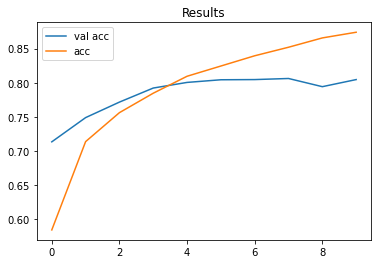

In [41]:
# plot
plt.plot(history.history['val_acc'], label = 'val acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend()
plt.title('Results');

In [47]:
model.save('../models/cnn5l20mfcc_02262021.h5', save_format='h5')

In [17]:
# reloaded_model = tensorflow.keras.models.load_model('../models/cnn02252021.h5')

In [42]:
y_out = np.apply_along_axis(np.argmax, axis=1, arr=y_test)

In [43]:
cm = confusion_matrix(y_out, model.predict_classes(X_test))

In [44]:
cm

array([[2484,  104,  158,  209,   88],
       [ 173, 2199,  135,  352,   46],
       [  87,   52, 2216,  247,   68],
       [ 214,  221,  261, 2241,   67],
       [ 198,   20,   50,   70, 2466]])

In [45]:
x = np.true_divide(cm, cm.sum(axis=0, keepdims=True))

Text(69.0, 0.5, 'Predicted')

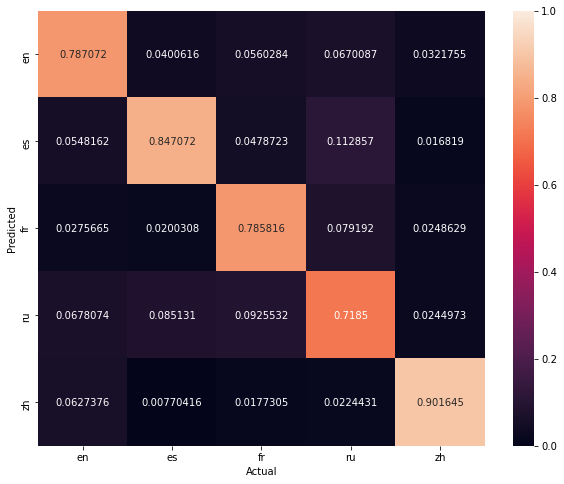

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(x, annot=True, vmin=0, vmax=1, fmt='g', xticklabels=['en', 'es', 'fr', 'ru', 'zh'], yticklabels=['en', 'es', 'fr', 'ru', 'zh'])
plt.xlabel("Actual")
plt.ylabel("Predicted")